In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error


from sklearn.linear_model import Lasso,LassoCV, LassoLarsIC
#from epftoolbox.evaluation import MASE
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime, timedelta
from pandas.tseries.offsets import MonthEnd, BDay, Week

import time

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from statistics import mean

In [2]:
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

def plot_predictions(data, train_predictions, test_predictions, scaler):
    """
    Plot actual data along with train and test predictions, using dates on the x-axis.

    Parameters:
    - data: The original DataFrame containing the actual target values.
    - train_predictions: Predicted values for the train dataset (scaled).
    - test_predictions: Predicted values for the test dataset (scaled).
    - scaler: Fitted scaler object used to inverse transform the scaled predictions.
    """
    # Ensure the index is used as the x-axis (datetime index)
    dates = data.index

    # Inverse transform the actual data to the original scale
    actual_data2 = data['Log_Return'].values.reshape(-1, 1)
    actual_data = scaler.inverse_transform(data['Log_Return'].values.reshape(-1, 1))

    # Prepare placeholders for plotting train and test predictions
    train_predict_plot = np.empty_like(actual_data)
    train_predict_plot[:] = np.nan
    train_predict_plot[:len(train_predictions)] = scaler.inverse_transform(train_predictions.reshape(-1, 1))

    test_predict_plot = np.empty_like(actual_data)
    test_predict_plot[:] = np.nan
    test_predict_plot[len(train_predictions):len(train_predictions) + len(test_predictions)] = scaler.inverse_transform(test_predictions.reshape(-1, 1))

    train_dates = data.index[:len(train_predictions)]
    test_dates = data.index[len(train_predictions):len(train_predictions) + len(test_predictions)]

    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Log_Return'], label="Actual Data", color="blue")
    plt.plot(train_dates, scaler.inverse_transform(train_predictions.reshape(-1, 1)), label="Train Predictions", color="orange")
    plt.plot(test_dates, scaler.inverse_transform(test_predictions.reshape(-1, 1)), label="Test Predictions", color="green")
    plt.title("Train and Test Predictions")
    plt.xlabel("Date")
    plt.ylabel("Value (Original Scale)")
    plt.legend()
    plt.grid()
    plt.show()

def calculate_metrics(y_true, y_pred, scaler):
    """
    Calculates RMSE and MAE evaluation metrics before and after inverse transformation.
    
    Parameters:
    - y_true: True values.
    - y_pred: Predicted values.
    - scaler: The target scaler used for inverse transformation.
    
    Returns:
    - RMSE and MAE values before and after inverse transformation.
    """
    # Compute metrics before inverse transformation
    rmse_scaled = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_scaled = mean_absolute_error(y_true, y_pred)
    
    print(f"Scaled RMSE: {rmse_scaled}, Scaled MAE: {mae_scaled}")
    
    # Compute metrics after inverse transformation
    y_true_original = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
    y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    
    rmse_original = np.sqrt(mean_squared_error(y_true_original, y_pred_original))
    mae_original = mean_absolute_error(y_true_original, y_pred_original)
    
    print(f"Original RMSE: {rmse_original}, Original MAE: {mae_original}")
    
    return rmse_original, mae_original

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from itertools import product

# Step 1: Split the data
def split_data(data, max_lag, sma_windows, train_start, train_end, test_start, test_end):
    """
    Splits the dataset into training and testing sets with lagged log returns and SMA features.
    
    Parameters:
    - data: DataFrame containing stock log returns.
    - max_lag: Maximum number of lagged days for log return features.
    - sma_windows: List of window sizes for SMA features (e.g., [10, 20]).
    - train_start, train_end: Date range for the training dataset.
    - test_start, test_end: Date range for the test dataset.

    Returns:
    - X_train, X_test, y_train, y_test: Scaled train-test feature sets and target values.
    """
    
    # Generate lagged log return features
    for lag in range(1, max_lag + 1):
        data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)

    # Generate SMA features
    for window in sma_windows:
        data[f'SMA_{window}'] = data['Log_Return'].rolling(window=window).mean()

    # Drop rows with NaN values due to lagging and SMA calculation
    data = data.dropna()

    # Split data into train and test sets based on provided dates
    train_data = data.loc[train_start:train_end]
    test_data = data.loc[test_start:test_end]

    # Extract features (X) and target (y)
    feature_columns = [f'Lagged_Log_Return_{lag}' for lag in range(1, max_lag + 1)] + \
                      [f'SMA_{window}' for window in sma_windows]
    
    X_train = train_data[feature_columns]
    y_train = train_data['Log_Return']
    X_test = test_data[feature_columns]
    y_test = test_data['Log_Return']

    return X_train, X_test, y_train, y_test

# Step 2: Scale the data

def scale_data(X_train, X_test, y_train, y_test):
    # Create scalers for features and target
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()
    
    # Scale features
    X_train_scaled = feature_scaler.fit_transform(X_train)
    X_test_scaled = feature_scaler.transform(X_test)
    
    # Scale target variable
    y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))
    
    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, feature_scaler, target_scaler

# Step 3: Model training with hyperparameter tuning
def model_training(train_data_scaled, y_train_scaled):


# Initialize LassoCV with a predefined number of alphas and other parameters
    lasso_cv = LassoCV(
        eps=1e-3,  # Length of the path
        n_alphas=100,  # Number of alphas along the regularization path
        fit_intercept=True,  # Whether to fit intercept
        precompute='auto',  # Precompute Gram matrix
        max_iter=10000,  # Maximum number of iterations
        tol=1e-4,  # Tolerance for optimization
        cv=10,  # Number of cross-validation folds for alpha selection
        random_state=42  # For reproducibility
    )

    # Define the hyperparameter space for Bayesian optimization excluding alpha and n_alphas
    param_space = {
        'eps': Real(1e-4, 1e-1, prior='log-uniform'),  # Length of the path
        'fit_intercept': Categorical([True, False]),
        'precompute': Categorical(['auto', True, False]),
        'max_iter': Integer(1000, 10000),
        'tol': Real(1e-4, 1e-2, prior='log-uniform')  # Tolerance for optimization
    }

    # Use BayesSearchCV to find the best combination of hyperparameters
    bayes_search = BayesSearchCV(
        estimator=lasso_cv,
        search_spaces=param_space,
        n_iter=50,
        cv=5,  # Number of cross-validation folds for hyperparameter optimization
        scoring='neg_mean_absolute_error',
        random_state=42,
        n_points=15
    )

    # Fit the model
    #bayes_search.fit(train_data_scaled, y_train)
    bayes_search.fit(train_data_scaled, y_train_scaled.ravel())

    # Get the best model and parameters
    best_model = bayes_search.best_estimator_
    best_params = bayes_search.best_params_

    # Display the best model parameters
    print("Best Model Parameters:")
    print(best_params)

    return best_model, best_params



# Step 4: Main workflow
# 🔹 Step 7: Main Function
def main(data):
    max_lag = 80
    train_start, train_end = "2000-01-01", "2014-12-31"
    test_start, test_end = "2015-01-01", "2024-01-01"
    
    sma_windows = [5,10,15]
    # Split Data for Evaluation
    X_train, X_test, y_train, y_test = split_data(data, max_lag,sma_windows, train_start, train_end, test_start, test_end)

    # Scale Data
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, feature_scaler, target_scaler = scale_data(X_train, X_test, y_train, y_test)

    # Train Model on Train Set (`2000-2014`)
    best_model, best_params = model_training(X_train_scaled, y_train_scaled)

    # Generate Predictions
    train_predictions_scaled = best_model.predict(X_train_scaled)
    test_predictions_scaled = best_model.predict(X_test_scaled)

    # Evaluate Train-Test Performance
    train_rmse, train_mae = calculate_metrics(y_train_scaled, train_predictions_scaled, target_scaler)
    test_rmse, test_mae = calculate_metrics(y_test_scaled, test_predictions_scaled, target_scaler)

    print(f"Train RMSE: {train_rmse:.4f}, Train MAE: {train_mae:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}")

    plot_predictions(data, y_train_scaled, y_test_scaled, target_scaler)
    
    # Train Final Model on Full Dataset (`2000-2023`)
    final_model = train_final_model(data, max_lag,sma_windows, feature_scaler, target_scaler, best_params)

    # Forecast Future (`2024`)
    future_predictions = forecast_future(data, final_model, target_scaler, max_lag, sma_windows,start_date="2024-01-01", end_date="2024-12-31" )


    print("Future Predictions:")
    print(future_predictions)

    return final_model, future_predictions
def train_final_model(data, max_lag, sma_windows,feature_scaler, target_scaler, best_params):
    X_full, _, y_full, _ = split_data(data, max_lag,sma_windows, "2000-01-01", "2023-12-31", None, None)
    X_full_scaled = feature_scaler.transform(X_full)
    y_full_scaled = target_scaler.transform(y_full.values.reshape(-1, 1))

    #  Check if `best_params` are properly set
    if best_params is None:
        raise ValueError("Error: No best parameters found for final model training.")

    #  Train LassoCV using the best hyperparameters
    final_model = LassoCV(
        eps=best_params['eps'],
        fit_intercept=best_params['fit_intercept'],
        precompute=best_params['precompute'],
        max_iter=best_params['max_iter'],
        tol=best_params['tol'],
        cv=10,
        random_state=42
    ).fit(X_full_scaled, y_full_scaled.ravel())

    #  Ensure the model is trained properly
    if final_model is None:
        raise ValueError("Final model training failed!")

    return final_model  # Must return the trained model


In [4]:
def forecast_future(data, model, scaler, max_lag, sma_windows, start_date="2024-01-01", end_date="2024-12-31"):
    """Forecast future log returns using the trained model with lagged returns and SMA features."""
    if model is None:
        raise ValueError("Cannot forecast because the model is not trained.")

    # Get the last available features (Lagged Log Returns + SMA)
    lagged_features = data.iloc[-1, :][[f'Lagged_Log_Return_{i}' for i in range(1, max_lag + 1)]].values
    sma_features = data.iloc[-1, :][[f'SMA_{w}' for w in sma_windows]].values

    future_dates = pd.date_range(start=start_date, end=end_date, freq="B")  
    future_forecasts = pd.DataFrame(index=future_dates)
    future_forecasts['Forecasted_Log_Return'] = np.nan

    for date in future_forecasts.index:
        # Combine lagged features and SMA features
        input_features = np.hstack((lagged_features, sma_features))

        # Predict scaled forecasted return
        forecasted_scaled = model.predict(input_features.reshape(1, -1))[0]

        # Inverse transform to original scale
        forecasted_original = scaler.inverse_transform([[forecasted_scaled]])[0][0]
        future_forecasts.at[date, 'Forecasted_Log_Return'] = forecasted_original

        # Update lagged features (shift left and insert new forecast)
        lagged_features = np.roll(lagged_features, -1)
        lagged_features[-1] = forecasted_scaled  # Use predicted value for next forecast

        # Update SMA values dynamically (simulate moving average)
        new_sma_values = []
        for window in sma_windows:
            recent_returns = np.concatenate(([forecasted_original], data['Log_Return'].values[-(window - 1):]))  # Add new forecast
            new_sma_values.append(np.mean(recent_returns))  # Compute new SMA
        
        sma_features = np.array(new_sma_values)  # Update SMA features for next prediction

    return future_forecasts


In [5]:
"""def forecast_future(data, model, scaler, max_lag, future_steps=10):
    Forecasts future values using lagged features.
    
    Parameters:
        data (DataFrame): Historical data containing the target column.
        model: Trained model.
        scaler: Scaler used to normalize data during training.
        max_lag (int): Number of lags used during training.
        future_steps (int): Number of steps to forecast.
        
    Returns:
        DataFrame: Forecasted values.

    # Get the last known data point
    last_known = data['Target'].values[-max_lag:]  # Last `max_lag` values
    forecasted_values = []

    for step in range(future_steps):
        # Scale the lagged features
        lagged_features = scaler.transform(last_known.reshape(1, -1))
        
        # Predict the next value
        predicted_scaled = model.predict(lagged_features)
        predicted_value = scaler.inverse_transform(predicted_scaled.reshape(-1, 1))[0][0]
        forecasted_values.append(predicted_value)
        
        # Update the lagged features
        last_known = np.roll(last_known, -1)  # Shift values
        last_known[-1] = predicted_value  # Add the new prediction

    # Create a DataFrame for the future dates
    future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=future_steps)
    forecast_df = pd.DataFrame({'Date': future_dates, 'Forecasted': forecasted_values})
    forecast_df.set_index('Date', inplace=True)

    return forecast_df
"""

"def forecast_future(data, model, scaler, max_lag, future_steps=10):\n    Forecasts future values using lagged features.\n    \n    Parameters:\n        data (DataFrame): Historical data containing the target column.\n        model: Trained model.\n        scaler: Scaler used to normalize data during training.\n        max_lag (int): Number of lags used during training.\n        future_steps (int): Number of steps to forecast.\n        \n    Returns:\n        DataFrame: Forecasted values.\n\n    # Get the last known data point\n    last_known = data['Target'].values[-max_lag:]  # Last `max_lag` values\n    forecasted_values = []\n\n    for step in range(future_steps):\n        # Scale the lagged features\n        lagged_features = scaler.transform(last_known.reshape(1, -1))\n        \n        # Predict the next value\n        predicted_scaled = model.predict(lagged_features)\n        predicted_value = scaler.inverse_transform(predicted_scaled.reshape(-1, 1))[0][0]\n        forecasted_v

In [6]:
def group_forecasts(forecast_df, year):
    """
    Groups the forecasted log returns month-wise and week-wise based on the given year.
    
    Parameters:
    - forecast_df: DataFrame with forecasted log returns indexed by date.
    - year: Year for which weeks should be grouped.
    
    Returns:
    - Dictionary with forecasted log returns per month and per week as lists.
    """
    forecast_df['Month'] = forecast_df.index.to_period('M')
    forecast_df['Week'] = forecast_df.index.to_period('W-SUN')  # Ensure weeks align with trading days
    
    grouped_month_forecast = {f"forecast_predictions_df_{i+1}m": values for i, (key, values) in enumerate(forecast_df.groupby('Month')['Forecasted_Log_Return'].apply(list).items())}
    grouped_week_forecast = {f"forecast_predictions_df_{i+1}w": values for i, (key, values) in enumerate(forecast_df[forecast_df.index.year == year].groupby(pd.Grouper(freq='W-FRI'))['Forecasted_Log_Return'].apply(list).items())}
    
    return grouped_month_forecast, grouped_week_forecast


In [7]:
# 🔹 Step 7: Main Function
def main(data):
    max_lag = 80
    train_start, train_end = "2000-01-01", "2014-12-31"
    test_start, test_end = "2015-01-01", "2024-01-01"
    sma_windows = [5,10,15]
    # Split Data for Evaluation
    X_train, X_test, y_train, y_test = split_data(data, max_lag,sma_windows, train_start, train_end, test_start, test_end)

    # Scale Data
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, feature_scaler, target_scaler = scale_data(X_train, X_test, y_train, y_test)

    # Train Model on Train Set (`2000-2014`)
    start_time = time.time()
    
    
    best_model, best_params = model_training(X_train_scaled, y_train)
    end_time = time.time()
    computaton_time = end_time - start_time
    print(f"Computation Time: {computaton_time:.2f} seconds")
    
    # Generate Predictions
    train_predictions_scaled = best_model.predict(X_train_scaled)
    test_predictions_scaled = best_model.predict(X_test_scaled)

    
    # Evaluate Train-Test Performance
    train_rmse, train_mae = calculate_metrics(y_train_scaled, train_predictions_scaled, target_scaler)
    test_rmse, test_mae = calculate_metrics(y_test_scaled, test_predictions_scaled, target_scaler)

    print(f"Train RMSE: {train_rmse:.4f}, Train MAE: {train_mae:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}")
    # Step 6: Compute evaluation metrics
    
    model_metrics={
                "training_set":{
                    "mae" : train_mae,
                    "rmse" : train_rmse
                },
                "test_set":{
                    "mae" : test_mae,
                    "rmse" : test_rmse
                },
                "time":computaton_time
                
        }

    #plot_predictions(data, y_train_scaled, y_test_scaled, target_scaler)
    
    # Train Final Model on Full Dataset (`2000-2023`)
    final_model = train_final_model(data, max_lag,sma_windows, feature_scaler, target_scaler, best_params)

    # Forecast Future (`2024`)
    future_predictions = forecast_future(data, final_model, target_scaler, max_lag, sma_windows,start_date="2024-01-01", end_date="2024-12-31" )

    print("Future Predictions:")
    print(future_predictions)

    return final_model, future_predictions, model_metrics

In [8]:
def run_workflow(tickers):
    """
    Runs the workflow for multiple stock tickers.
    """
    results = {}
    
    for ticker in tickers:
        print(f"Processing {ticker}...")
        
        # Step 1: Download data
        data = yf.download(ticker, start="2000-01-01", end="2023-12-31")
        
        # Step 2: Compute log returns
        data['Log_Return'] = np.log(data['Close'] / data['Close'].shift(1))
        
        # Step 3: Drop NaN values
        data = data.dropna()
        
        # Step 4: Ensure index is datetime
        data.index = pd.to_datetime(data.index)
        
        # Step 5: Run the main function
        final_model, future_predictions, model_metrics = main(data)
        
        # Step 6: Group forecasted returns month-wise and week-wise for 2024
        monthly_forecasts, weekly_forecasts = group_forecasts(future_predictions, year=2024)
        
        # Step 7: Store results in a dictionary
        results[ticker] = {
            #"final_model": final_model,
            #"future_predictions": future_predictions,
            "monthly_forecast_results": monthly_forecasts,
            "weekly_forecast_results": weekly_forecasts,
            "model_metrics": model_metrics
        }
    
    return results

# List of tickers to process
tickers = ['SMH', 'SOXX', 'PSI', 'XSD', 'IYW', 'XLK', 'VGT', 'FTEC', 'IGM', 'IXN']

#tickers = ['SMH', 'SOXX']

#tickers = ['SMH', 'SOXX', 'PSI','XSD', 'IYW', 'XLK', 'VGT',]

# Execute the workflow for multiple tickers
results = run_workflow(tickers)


Processing SMH...


[*********************100%%**********************]  1 of 1 completed
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_825/1583700493.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_825/1583700493.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_

/Users/pranavsrinivasvenkatesh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00028955853774618507, tolerance: 0.00017159023275225118
  model = cd_fast.enet_coordinate_descent_gram(
/Users/pranavsrinivasvenkatesh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002680837447912401, tolerance: 0.00015379415248263244
  model = cd_fast.enet_coordinate_descent_gram(
/Users/pranavsrinivasvenkatesh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000283585285684051, tolerance: 0.0001713074304346768
  model = cd_fast.enet_coordinate_d

Best Model Parameters:
OrderedDict([('eps', 0.0001), ('fit_intercept', True), ('max_iter', 1000), ('precompute', True), ('tol', 0.0001)])
Computation Time: 126.57 seconds
Scaled RMSE: 0.9769151101459941, Scaled MAE: 0.679440596771426
Original RMSE: 0.022565346324377088, Original MAE: 0.01569410915416942
Scaled RMSE: 0.8027199069397166, Scaled MAE: 0.5783252707507662
Original RMSE: 0.01854168546831001, Original MAE: 0.013358489276186878
Train RMSE: 0.0226, Train MAE: 0.0157
Test RMSE: 0.0185, Test MAE: 0.0134


/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_825/1583700493.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_825/1583700493.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'SMA_{window}'] = data['Log_Return'].rolling(window=window).mean()


Future Predictions:
            Forecasted_Log_Return
2024-01-01              -0.000330
2024-01-02              -0.000900
2024-01-03              -0.000265
2024-01-04              -0.000027
2024-01-05               0.000049
2024-01-08               0.000501
2024-01-09              -0.000573
2024-01-10              -0.000757
2024-01-11              -0.001090
2024-01-12              -0.001495
2024-01-15              -0.001269
2024-01-16              -0.001486
2024-01-17              -0.001073
2024-01-18              -0.000517
2024-01-19               0.000012
2024-01-22               0.000450
2024-01-23               0.000507
2024-01-24               0.000318
2024-01-25               0.000091
2024-01-26               0.000191
2024-01-29              -0.000010
2024-01-30               0.000247
2024-01-31               0.000416
2024-02-01               0.000093
2024-02-02              -0.000103
2024-02-05              -0.000236
2024-02-06              -0.000600
2024-02-07              -0.0

[*********************100%%**********************]  1 of 1 completed
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_825/1583700493.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_825/1583700493.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_

/Users/pranavsrinivasvenkatesh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.399e-04, tolerance: 8.376e-05
  model = cd_fast.enet_coordinate_descent(


Best Model Parameters:
OrderedDict([('eps', 0.00014663730351947653), ('fit_intercept', True), ('max_iter', 9233), ('precompute', 'auto'), ('tol', 0.0001)])
Computation Time: 134.33 seconds
Scaled RMSE: 0.979342210947092, Scaled MAE: 0.7092364775435549
Original RMSE: 0.020241774700136023, Original MAE: 0.014659028097718031
Scaled RMSE: 0.9177063636351696, Scaled MAE: 0.657253984356703
Original RMSE: 0.018967839071921466, Original MAE: 0.013584615187013361
Train RMSE: 0.0202, Train MAE: 0.0147
Test RMSE: 0.0190, Test MAE: 0.0136


/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_825/1583700493.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_825/1583700493.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'SMA_{window}'] = data['Log_Return'].rolling(window=window).mean()


Future Predictions:
            Forecasted_Log_Return
2024-01-01              -0.000214
2024-01-02              -0.000847
2024-01-03              -0.000137
2024-01-04               0.000121
2024-01-05               0.000247
2024-01-08               0.000735
2024-01-09              -0.000488
2024-01-10              -0.000704
2024-01-11              -0.000912
2024-01-12              -0.001530
2024-01-15              -0.001133
2024-01-16              -0.001361
2024-01-17              -0.001086
2024-01-18              -0.000273
2024-01-19               0.000129
2024-01-22               0.000583
2024-01-23               0.000604
2024-01-24               0.000263
2024-01-25               0.000149
2024-01-26               0.000273
2024-01-29               0.000115
2024-01-30               0.000270
2024-01-31               0.000541
2024-02-01               0.000212
2024-02-02               0.000079
2024-02-05               0.000133
2024-02-06              -0.000405
2024-02-07              -0.0

[*********************100%%**********************]  1 of 1 completed
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_825/1583700493.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_825/1583700493.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_

Best Model Parameters:
OrderedDict([('eps', 0.00015213900811879256), ('fit_intercept', True), ('max_iter', 10000), ('precompute', True), ('tol', 0.00010681399683446619)])
Computation Time: 106.68 seconds
Scaled RMSE: 0.9817615839135697, Scaled MAE: 0.7312472785760661
Original RMSE: 0.01791575666553107, Original MAE: 0.013344225848680138
Scaled RMSE: 1.0773383499697686, Scaled MAE: 0.778344064476432
Original RMSE: 0.019659897108178493, Original MAE: 0.014203675403179973
Train RMSE: 0.0179, Train MAE: 0.0133
Test RMSE: 0.0197, Test MAE: 0.0142


/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_825/1583700493.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_825/1583700493.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'SMA_{window}'] = data['Log_Return'].rolling(window=window).mean()


Future Predictions:
            Forecasted_Log_Return
2024-01-01              -0.000045
2024-01-02              -0.000718
2024-01-03              -0.000203
2024-01-04              -0.000033
2024-01-05               0.000090
2024-01-08               0.000696
2024-01-09              -0.000480
2024-01-10              -0.000712
2024-01-11              -0.000879
2024-01-12              -0.001460
2024-01-15              -0.000958
2024-01-16              -0.000947
2024-01-17              -0.000755
2024-01-18              -0.000022
2024-01-19               0.000291
2024-01-22               0.000640
2024-01-23               0.000676
2024-01-24               0.000365
2024-01-25               0.000348
2024-01-26               0.000393
2024-01-29               0.000273
2024-01-30               0.000394
2024-01-31               0.000456
2024-02-01               0.000196
2024-02-02               0.000132
2024-02-05               0.000179
2024-02-06              -0.000211
2024-02-07              -0.0

[*********************100%%**********************]  1 of 1 completed
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_825/1583700493.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_825/1583700493.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_

Best Model Parameters:
OrderedDict([('eps', 0.0001), ('fit_intercept', True), ('max_iter', 1000), ('precompute', True), ('tol', 0.0001)])
Computation Time: 102.38 seconds
Scaled RMSE: 0.9807742409045684, Scaled MAE: 0.7234636892936668
Original RMSE: 0.018867032163598037, Original MAE: 0.013917181065552729
Scaled RMSE: 1.0265136708460236, Scaled MAE: 0.7497154575676793
Original RMSE: 0.019746915892043183, Original MAE: 0.01442218306878673
Train RMSE: 0.0189, Train MAE: 0.0139
Test RMSE: 0.0197, Test MAE: 0.0144


/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_825/1583700493.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_825/1583700493.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'SMA_{window}'] = data['Log_Return'].rolling(window=window).mean()


Future Predictions:
            Forecasted_Log_Return
2024-01-01              -0.000089
2024-01-02              -0.000825
2024-01-03              -0.000231
2024-01-04              -0.000034
2024-01-05               0.000142
2024-01-08               0.000735
2024-01-09              -0.000680
2024-01-10              -0.001021
2024-01-11              -0.001059
2024-01-12              -0.001467
2024-01-15              -0.000975
2024-01-16              -0.000984
2024-01-17              -0.000948
2024-01-18              -0.000246
2024-01-19               0.000090
2024-01-22               0.000324
2024-01-23               0.000365
2024-01-24              -0.000145
2024-01-25              -0.000138
2024-01-26               0.000141
2024-01-29              -0.000034
2024-01-30               0.000110
2024-01-31               0.000462
2024-02-01               0.000083
2024-02-02              -0.000078
2024-02-05               0.000175
2024-02-06              -0.000570
2024-02-07              -0.0

[*********************100%%**********************]  1 of 1 completed
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_825/1583700493.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_825/1583700493.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_

Best Model Parameters:
OrderedDict([('eps', 0.00017829867772781023), ('fit_intercept', True), ('max_iter', 1000), ('precompute', True), ('tol', 0.0001)])
Computation Time: 139.37 seconds
Scaled RMSE: 0.9818387066751729, Scaled MAE: 0.6608766547355277
Original RMSE: 0.017843072752241625, Original MAE: 0.012010190829241082
Scaled RMSE: 0.8319072262229006, Scaled MAE: 0.5736390557005956
Original RMSE: 0.015118349948614924, Original MAE: 0.0104248114632327
Train RMSE: 0.0178, Train MAE: 0.0120
Test RMSE: 0.0151, Test MAE: 0.0104


/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_825/1583700493.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_825/1583700493.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'SMA_{window}'] = data['Log_Return'].rolling(window=window).mean()


Future Predictions:
            Forecasted_Log_Return
2024-01-01              -0.000155
2024-01-02              -0.000380
2024-01-03              -0.000110
2024-01-04              -0.000091
2024-01-05              -0.000186
2024-01-08              -0.000053
2024-01-09              -0.000298
2024-01-10              -0.000390
2024-01-11              -0.000378
2024-01-12              -0.000390
2024-01-15              -0.000546
2024-01-16              -0.000685
2024-01-17              -0.000408
2024-01-18              -0.000403
2024-01-19              -0.000043
2024-01-22               0.000205
2024-01-23               0.000066
2024-01-24               0.000140
2024-01-25              -0.000141
2024-01-26              -0.000065
2024-01-29              -0.000045
2024-01-30              -0.000118
2024-01-31               0.000060
2024-02-01              -0.000211
2024-02-02              -0.000233
2024-02-05              -0.000257
2024-02-06              -0.000397
2024-02-07              -0.0

[*********************100%%**********************]  1 of 1 completed
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_825/1583700493.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_825/1583700493.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_

Best Model Parameters:
OrderedDict([('eps', 0.0001), ('fit_intercept', True), ('max_iter', 1000), ('precompute', True), ('tol', 0.0001)])
Computation Time: 140.14 seconds
Scaled RMSE: 0.9831199404023467, Scaled MAE: 0.6634022756758037
Original RMSE: 0.016604524741446174, Original MAE: 0.011204614052973473
Scaled RMSE: 0.8626668538883949, Scaled MAE: 0.5876932490903573
Original RMSE: 0.01457011757197514, Original MAE: 0.00992591716826338
Train RMSE: 0.0166, Train MAE: 0.0112
Test RMSE: 0.0146, Test MAE: 0.0099


/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_825/1583700493.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_825/1583700493.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'SMA_{window}'] = data['Log_Return'].rolling(window=window).mean()


Future Predictions:
            Forecasted_Log_Return
2024-01-01              -0.000161
2024-01-02              -0.000334
2024-01-03              -0.000089
2024-01-04              -0.000082
2024-01-05              -0.000079
2024-01-08               0.000023
2024-01-09              -0.000198
2024-01-10              -0.000277
2024-01-11              -0.000377
2024-01-12              -0.000431
2024-01-15              -0.000615
2024-01-16              -0.000668
2024-01-17              -0.000417
2024-01-18              -0.000366
2024-01-19              -0.000019
2024-01-22               0.000151
2024-01-23              -0.000018
2024-01-24               0.000076
2024-01-25              -0.000169
2024-01-26              -0.000127
2024-01-29              -0.000073
2024-01-30              -0.000133
2024-01-31               0.000026
2024-02-01              -0.000209
2024-02-02              -0.000220
2024-02-05              -0.000223
2024-02-06              -0.000381
2024-02-07              -0.0

[*********************100%%**********************]  1 of 1 completed
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_825/1583700493.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_825/1583700493.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_

Best Model Parameters:
OrderedDict([('eps', 0.0001), ('fit_intercept', True), ('max_iter', 9010), ('precompute', 'auto'), ('tol', 0.0001)])
Computation Time: 117.69 seconds
Scaled RMSE: 0.9866093508257052, Scaled MAE: 0.684248340452556
Original RMSE: 0.013219426921979782, Original MAE: 0.009168138256066929
Scaled RMSE: 1.0992017770788278, Scaled MAE: 0.7532728087704481
Original RMSE: 0.014728035521296102, Original MAE: 0.01009298648905117
Train RMSE: 0.0132, Train MAE: 0.0092
Test RMSE: 0.0147, Test MAE: 0.0101


/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_825/1583700493.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_825/1583700493.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'SMA_{window}'] = data['Log_Return'].rolling(window=window).mean()


Future Predictions:
            Forecasted_Log_Return
2024-01-01               0.000231
2024-01-02               0.000074
2024-01-03               0.000292
2024-01-04               0.000312
2024-01-05               0.000291
2024-01-08               0.000390
2024-01-09               0.000143
2024-01-10               0.000042
2024-01-11              -0.000008
2024-01-12              -0.000030
2024-01-15              -0.000123
2024-01-16              -0.000110
2024-01-17               0.000081
2024-01-18               0.000105
2024-01-19               0.000359
2024-01-22               0.000430
2024-01-23               0.000316
2024-01-24               0.000345
2024-01-25               0.000177
2024-01-26               0.000263
2024-01-29               0.000272
2024-01-30               0.000276
2024-01-31               0.000402
2024-02-01               0.000214
2024-02-02               0.000184
2024-02-05               0.000209
2024-02-06               0.000082
2024-02-07              -0.0

[*********************100%%**********************]  1 of 1 completed
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_825/1583700493.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_825/1583700493.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_

Best Model Parameters:
OrderedDict([('eps', 0.0001), ('fit_intercept', True), ('max_iter', 1000), ('precompute', 'auto'), ('tol', 0.0001)])
Computation Time: 58.53 seconds
Scaled RMSE: 0.991381515947231, Scaled MAE: 0.7433337368221724
Original RMSE: 0.008550047256267077, Original MAE: 0.006410789867243662
Scaled RMSE: 1.7236440892212137, Scaled MAE: 1.1769421948426224
Original RMSE: 0.014865355242926714, Original MAE: 0.010150392378643805
Train RMSE: 0.0086, Train MAE: 0.0064
Test RMSE: 0.0149, Test MAE: 0.0102


/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_825/1583700493.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_825/1583700493.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'SMA_{window}'] = data['Log_Return'].rolling(window=window).mean()


Future Predictions:
            Forecasted_Log_Return
2024-01-01               0.000580
2024-01-02               0.000476
2024-01-03               0.000616
2024-01-04               0.000617
2024-01-05               0.000605
2024-01-08               0.000691
2024-01-09               0.000543
2024-01-10               0.000489
2024-01-11               0.000458
2024-01-12               0.000422
2024-01-15               0.000350
2024-01-16               0.000357
2024-01-17               0.000482
2024-01-18               0.000500
2024-01-19               0.000661
2024-01-22               0.000710
2024-01-23               0.000637
2024-01-24               0.000657
2024-01-25               0.000549
2024-01-26               0.000596
2024-01-29               0.000600
2024-01-30               0.000588
2024-01-31               0.000675
2024-02-01               0.000557
2024-02-02               0.000550
2024-02-05               0.000566
2024-02-06               0.000476
2024-02-07               0.0

[*********************100%%**********************]  1 of 1 completed
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_825/1583700493.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_825/1583700493.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_

Best Model Parameters:
OrderedDict([('eps', 0.0001), ('fit_intercept', True), ('max_iter', 9001), ('precompute', 'auto'), ('tol', 0.0001)])
Computation Time: 137.90 seconds
Scaled RMSE: 0.9843423428238691, Scaled MAE: 0.683408404844996
Original RMSE: 0.015421380621574257, Original MAE: 0.01070674365268404
Scaled RMSE: 0.9403054442038262, Scaled MAE: 0.6476585640553981
Original RMSE: 0.014731468438110587, Original MAE: 0.010146662187128598
Train RMSE: 0.0154, Train MAE: 0.0107
Test RMSE: 0.0147, Test MAE: 0.0101


/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_825/1583700493.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_825/1583700493.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'SMA_{window}'] = data['Log_Return'].rolling(window=window).mean()


Future Predictions:
            Forecasted_Log_Return
2024-01-01               0.000053
2024-01-02              -0.000176
2024-01-03               0.000075
2024-01-04               0.000100
2024-01-05              -0.000004
2024-01-08               0.000132
2024-01-09              -0.000164
2024-01-10              -0.000233
2024-01-11              -0.000215
2024-01-12              -0.000252
2024-01-15              -0.000343
2024-01-16              -0.000455
2024-01-17              -0.000204
2024-01-18              -0.000105
2024-01-19               0.000221
2024-01-22               0.000414
2024-01-23               0.000327
2024-01-24               0.000334
2024-01-25               0.000103
2024-01-26               0.000196
2024-01-29               0.000189
2024-01-30               0.000161
2024-01-31               0.000283
2024-02-01               0.000050
2024-02-02              -0.000010
2024-02-05               0.000008
2024-02-06              -0.000101
2024-02-07              -0.0

[*********************100%%**********************]  1 of 1 completed
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_825/1583700493.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_825/1583700493.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_

Best Model Parameters:
OrderedDict([('eps', 0.0001), ('fit_intercept', True), ('max_iter', 4441), ('precompute', True), ('tol', 0.0001)])
Computation Time: 122.87 seconds
Scaled RMSE: 0.9852217897841645, Scaled MAE: 0.6693272274581649
Original RMSE: 0.014569061714237424, Original MAE: 0.009897740574732635
Scaled RMSE: 0.9791988682360047, Scaled MAE: 0.6712238738617611
Original RMSE: 0.014479997184153924, Original MAE: 0.009925787415343145
Train RMSE: 0.0146, Train MAE: 0.0099
Test RMSE: 0.0145, Test MAE: 0.0099


/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_825/1583700493.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'Lagged_Log_Return_{lag}'] = data['Log_Return'].shift(lag)
/var/folders/14/ljpzpqp91g1dpqy4sw00h0vm0000gn/T/ipykernel_825/1583700493.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'SMA_{window}'] = data['Log_Return'].rolling(window=window).mean()


Future Predictions:
            Forecasted_Log_Return
2024-01-01               0.000085
2024-01-02              -0.000077
2024-01-03               0.000192
2024-01-04               0.000215
2024-01-05               0.000212
2024-01-08               0.000327
2024-01-09               0.000076
2024-01-10              -0.000008
2024-01-11              -0.000088
2024-01-12              -0.000124
2024-01-15              -0.000242
2024-01-16              -0.000269
2024-01-17              -0.000070
2024-01-18              -0.000024
2024-01-19               0.000268
2024-01-22               0.000400
2024-01-23               0.000283
2024-01-24               0.000324
2024-01-25               0.000107
2024-01-26               0.000146
2024-01-29               0.000183
2024-01-30               0.000148
2024-01-31               0.000290
2024-02-01               0.000110
2024-02-02               0.000057
2024-02-05               0.000033
2024-02-06              -0.000120
2024-02-07              -0.0

In [9]:
#formatted_dict = {f"forecast_predictions_df_{i+1}": values for i, values in enumerate(grouped_corrected_data.values())}

#formatted_dict

Overall mean Training MAE: 0.011701276139906213
Overall mean Test MAE: 0.011623552003682975
Overall mean Training RMSE: 0.016579742386138855
Overall mean Test RMSE: 0.016540966144753054
Total time elapsed to run the model: 1186.46 seconds
Average time consumed by model to train on an ETF: 118.65 seconds


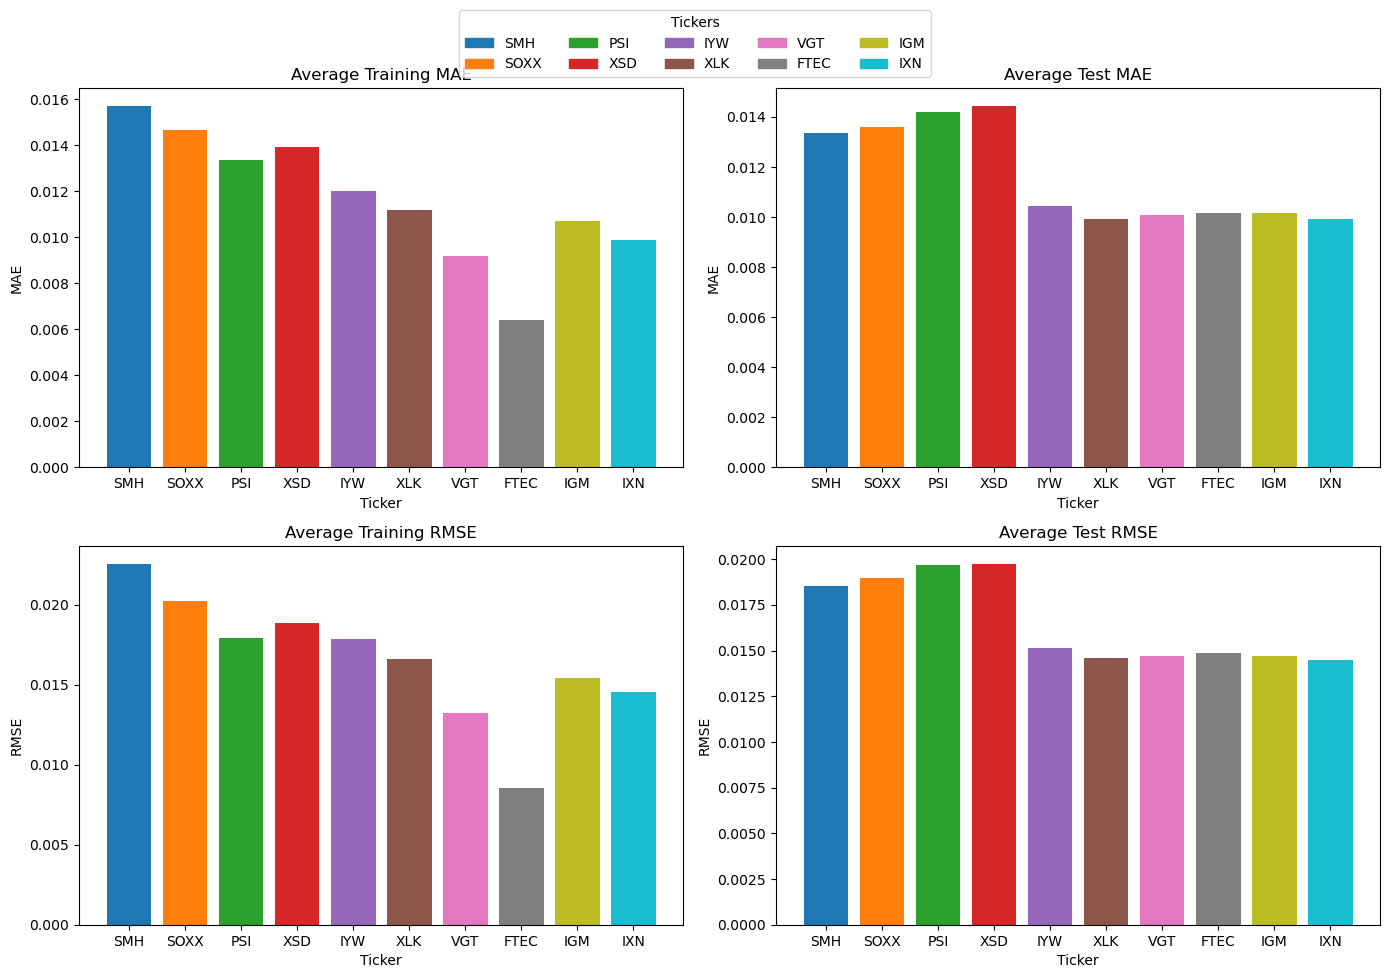

In [10]:
def plot_model_metrics(tickers, results):
    
    
    # --- 1. Gather metrics from 'results' for each ticker ---
    avg_training_mae = []
    avg_test_mae = []
    avg_training_rmse = []
    avg_test_rmse = []

    computation_time = []
    
    for ticker in tickers:
        model_metrics = results[ticker].get("model_metrics", {})
        
        train_set = model_metrics.get("training_set", {})
        test_set = model_metrics.get("test_set", {})
        
        avg_training_mae.append(train_set.get("mae", float('nan')))
        avg_test_mae.append(test_set.get("mae", float('nan')))
        avg_training_rmse.append(train_set.get("rmse", float('nan')))
        avg_test_rmse.append(test_set.get("rmse", float('nan')))

        computation_time.append(results[ticker].get("model_metrics", {}).get("time", {})) 
    
    # (Optional) Print some global averages if you want
    print("Overall mean Training MAE:", mean(avg_training_mae))
    print("Overall mean Test MAE:", mean(avg_test_mae))
    print("Overall mean Training RMSE:", mean(avg_training_rmse))
    print("Overall mean Test RMSE:", mean(avg_test_rmse))

    print(f"Total time elapsed to run the model: {sum(computation_time):.2f} seconds" )
    print(f"Average time consumed by model to train on an ETF: {mean(computation_time):.2f} seconds", )
    # --- 2. Define a color palette for each ticker (must match the number of tickers) ---
    # Example: 10 distinct colors
    colors = [
        'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
        'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
    ]
    # If you have more than 10 tickers, you need more colors or a different approach.

    # --- 3. Set up a 2×2 subplot grid ---
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    x_positions = range(len(tickers))  # One position per ticker

    # --- Subplot 1: Average Training MAE ---
    ax = axs[0, 0]
    ax.bar(x_positions, avg_training_mae, color=colors[:len(tickers)])
    ax.set_title("Average Training MAE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("MAE")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- Subplot 2: Average Test MAE ---
    ax = axs[0, 1]
    ax.bar(x_positions, avg_test_mae, color=colors[:len(tickers)])
    ax.set_title("Average Test MAE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("MAE")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- Subplot 3: Average Training RMSE ---
    ax = axs[1, 0]
    ax.bar(x_positions, avg_training_rmse, color=colors[:len(tickers)])
    ax.set_title("Average Training RMSE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("RMSE")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- Subplot 4: Average Test RMSE ---
    ax = axs[1, 1]
    ax.bar(x_positions, avg_test_rmse, color=colors[:len(tickers)])
    ax.set_title("Average Test RMSE")
    ax.set_xlabel("Ticker")
    ax.set_ylabel("RMSE")
    ax.set_xticks(x_positions)
    ax.set_xticklabels(tickers)

    # --- 4. Create a single legend for the entire figure ---
    legend_handles = [
        mpatches.Patch(color=c, label=ticker)
        for c, ticker in zip(colors[:len(tickers)], tickers)
    ]
    # Adjust spacing to make room at the top for the legend
    plt.tight_layout(rect=[0, 0, 1, 0.93])

    fig.legend(
        handles=legend_handles,
        title="Tickers",
        loc="upper center",
        bbox_to_anchor=(0.5, 0.98),
        ncol=min(5, len(tickers))  # Use up to 5 columns or fewer if <5 tickers
    )

    plt.show()
plot_model_metrics(tickers, results)

In [11]:
def calculate_sharpe_ratio(returns, annual_risk_free_rate=0.1,period='daily'):
    #excess_returns = rate_of_return(returns) - risk_free_rate
    
    # Convert annual risk-free rate to daily rate
    daily_risk_free_rate = (1 + annual_risk_free_rate) ** (1/252) - 1
    
    # Calculate mean daily log return
    mean_return = np.mean(returns)
    
    # Calculate excess daily log return
    excess_return = mean_return - daily_risk_free_rate
    
    # Calculate standard deviation of daily log returns
    std_return = np.std(returns)
    
    # Print diagnostic information
    #print(f"Mean Daily Log Return: {mean_return}")
    #print(f"Excess Daily Log Return: {excess_return}")
    #print(f"Standard Deviation of Daily Log Returns: {std_return}")
    
    # Check for zero standard deviation to avoid division by zero
    epsilon = 0
    # Check for zero standard deviation to avoid division by zero
    if std_return == 0:
        epsilon = 1e-5 
    
    # Calculate Sharpe ratio
    #sharpe_ratio = (excess_return / std_return) * np.sqrt(252)  # Annualize the Sharpe ratio
    sharpe_ratio = (excess_return / (std_return +  epsilon)) # Annualize the Sharpe ratio

    return sharpe_ratio
    #return excess_returns / np.std(returns)


def calculate_rachev_ratio(returns, lower_percentile=5, upper_percentile=95):
    # Step 1: Sort the returns
    sorted_returns = np.sort(returns)
    
    # Step 2: Determine the percentiles
    lower_threshold = np.percentile(sorted_returns, lower_percentile)
    upper_threshold = np.percentile(sorted_returns, upper_percentile)
    
    # Step 3: Calculate Expected Shortfall (ES)
    es = np.mean(sorted_returns[sorted_returns <= lower_threshold])
    
    # Step 4: Calculate Expected Gain (EG)
    eg = np.mean(sorted_returns[sorted_returns >= upper_threshold])
    
    # Step 5: Compute the Rachev Ratio
    rachev_ratio = eg / -es
    return rachev_ratio


"""def calculate_volatility_clustering(returns):
    squared_returns = returns ** 2
    n = len(squared_returns)
    
    # Mean of squared returns
    mean_squared_returns = np.mean(squared_returns)
    
    # Calculate the numerator and denominator for autocorrelation at lag 1
    numerator = np.sum((squared_returns[:-1] - mean_squared_returns) * (squared_returns[1:] - mean_squared_returns))
    denominator = np.sum((squared_returns - mean_squared_returns) ** 2)
    
    if denominator == 0:
        return 0  # Avoid division by zero
    
    rho_1 = numerator / denominator
    return rho_1"""
def calculate_volatility_clustering(returns):
    # Ensure returns is a NumPy array
    returns = np.array(returns)
    squared_returns = returns ** 2
    n = len(squared_returns)

    # Mean of squared returns
    mean_squared = np.mean(squared_returns)
    clustering = np.sum((squared_returns - mean_squared) ** 2) / (n - 1 if n > 1 else 1)
    return clustering

def calculate_sortino_ratio(log_returns, target_log_return=0.04):
    """
    Calculate the Sortino Ratio using log returns.
    
    Parameters:
    - log_returns (array-like): Array or list of log returns for the period.
    - target_log_return (float): The target log return. Default is 0, which is often used as a benchmark.
    
    Returns:
    - float: The Sortino Ratio.
    """
    # Convert input to a NumPy array for easier calculations
    log_returns = np.array(log_returns)
    
    # Calculate the average period log return (R)
    avg_log_return = np.mean(log_returns)
    
    # Calculate the Target Downside Deviation (TDD)
    downside_deviation = np.sqrt(
        np.mean(np.square(np.maximum(0, target_log_return - log_returns)))
    )
    
    # Calculate Sortino Ratio
    #sortino_ratio_value = (avg_log_return - target_log_return) / downside_deviation
    epsilon = 1e-8
    
    # Add epsilon to downside_deviation to prevent division by zero
    #if downside_deviation == 0:
     #   return np.nan  # Return NaN if downside deviation is zero
    
    # Calculate Sortino Ratio
    sortino_ratio_value = (avg_log_return - target_log_return) / (downside_deviation + epsilon)
    
    return sortino_ratio_value


def compute_risk_metrics(results):
    risk_metrics_results = {}
    for ticker, data in results.items():
        risk_metrics_results[ticker] = {}
        for month in range(1, 13):
            future_predictions = data['monthly_forecast_results'][f'forecast_predictions_df_{month}m']
            
            sharpe = calculate_sharpe_ratio(future_predictions)
            rachev = calculate_rachev_ratio(future_predictions)
            volatility_clustering = calculate_volatility_clustering(future_predictions)
            sortino = calculate_sortino_ratio(future_predictions)
            
            risk_metrics_results[ticker][f'risk_metrics_{month}m'] = {
                'Sharpe Ratio': sharpe,
                'Rachev Ratio': rachev,
                'Volatility Clustering': volatility_clustering,
                'Sortino Ratio': sortino
            }
    #print(risk_metrics_results)
    return risk_metrics_results


In [12]:
def calculate_composite_score(
    forecasted_values, risk_percentage, rachev_ratio, sharpe_ratio, sortino_ratio, volatility_clustering, 
    mean_forecast, std_forecast, mean_rachev, std_rachev, mean_sharpe, std_sharpe, mean_sortino, std_sortino, 
    mean_volatility_clustering, std_volatility_clustering
):
    epsilon = 1e-8  # To prevent division by zero
    forecasted_mean = np.mean(forecasted_values)

    # Normalize the components with epsilon
    forecasted_mean_normalized = (forecasted_mean - mean_forecast) / (std_forecast + epsilon)
    rachev_normalized = (rachev_ratio - mean_rachev) / (std_rachev + epsilon)
    sharpe_normalized = (sharpe_ratio - mean_sharpe) / (std_sharpe + epsilon)
    sortino_normalized = (sortino_ratio - mean_sortino) / (std_sortino + epsilon)
    volatility_clustering_normalized = (volatility_clustering - mean_volatility_clustering) / (std_volatility_clustering + epsilon)

    # Composite score calculation
    score = (
        forecasted_mean_normalized
        - (risk_percentage * rachev_normalized)
        + sharpe_normalized
        + sortino_normalized
        - volatility_clustering_normalized
    )

    return score

def compute_composite_scores(results, risk_metrics_results, risk_percentage):
    composite_scores = {}
    
    for month in range(1, 13):
        forecasted_values = {
            ticker: data['monthly_forecast_results'][f'forecast_predictions_df_{month}m']
            for ticker, data in results.items()
        }
        
        mean_forecast = np.mean([np.mean(values) for values in forecasted_values.values()])
        std_forecast = np.std([np.mean(values) for values in forecasted_values.values()])
        
        for ticker, metrics in risk_metrics_results.items():
            risk_metrics = metrics[f'risk_metrics_{month}m']
            composite_scores.setdefault(ticker, {})[f'composite_score_{month}m'] = calculate_composite_score(
                forecasted_values[ticker], risk_percentage, risk_metrics['Rachev Ratio'], risk_metrics['Sharpe Ratio'],
                risk_metrics['Sortino Ratio'], risk_metrics['Volatility Clustering'], mean_forecast, std_forecast,
                np.mean([m[f'risk_metrics_{month}m']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{month}m']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{month}m']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{month}m']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{month}m']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{month}m']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{month}m']['Volatility Clustering'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{month}m']['Volatility Clustering'] for m in risk_metrics_results.values()])
            )
    
    return composite_scores


In [13]:
def select_top_etfs_monthly(df, month_label, return_scores=False):
    df_sorted = df.sort_values(by='Score', ascending=False).head(2)
    if return_scores:
        return list(df_sorted.itertuples(index=False, name=None))  # Returns tuples (ETF, Score)
    return list(df_sorted['ETF'])  # Returns only ETF names

def generate_month_ranges(start_date, end_date):
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    month_ranges = []
    while start < end:
        month_start = start
        month_end = (start + timedelta(days=31)).replace(day=1) - timedelta(days=1)
        if month_end > end:
            month_end = end
        month_ranges.append((month_start.strftime('%Y-%m-%d'), month_end.strftime('%Y-%m-%d')))
        start = month_end + timedelta(days=1)
    return month_ranges

def gather_etf_data(tickers, month_ranges):
    etf_histories = {}
    for start_date, end_date in month_ranges:
        month = f"{start_date} to {end_date}"
        etf_histories[month] = {}
        for ticker in tickers:
            etf_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
            if etf_data.empty:
                print(f"No data found for {ticker} in {month}")
                continue
            etf_data.index = pd.to_datetime(etf_data.index)
            etf_histories[month][ticker] = etf_data
    return etf_histories

def initialize_shares(top_etfs, etf_histories, month, investment_amount=50000):
    ticker_shares = {}
    first_trading_day_start = month.split(" to ")[0]
    for ticker in top_etfs:
        etf_history = etf_histories.get(month, {}).get(ticker)
        if etf_history is not None:
            first_trading_day = pd.to_datetime(first_trading_day_start) + BDay(1)
            if first_trading_day not in etf_history.index:
                first_trading_day = etf_history.index[etf_history.index.searchsorted(first_trading_day)]
            price = etf_history.loc[first_trading_day, 'Close']
            num_shares = (investment_amount * 0.9975) / price
            print(f"Buy {ticker}: {num_shares:.2f} shares at {price:.2f}.")
            ticker_shares[ticker] = num_shares
        else:
            print(f"No data found for {ticker} in {month}")
    return ticker_shares

def manage_portfolio(prev_top_etfs, curr_top_etfs, prev_month, curr_month, ticker_shares, etf_histories):
    print(f"Top 2 ETFs for {prev_month}: {prev_top_etfs}")
    print(f"Top 2 ETFs for {curr_month}: {curr_top_etfs}")
    etf_histories_curr = etf_histories.get(curr_month, {})
    common_etfs = set(prev_top_etfs) & set(curr_top_etfs)
    etfs_to_sell = set(prev_top_etfs) - common_etfs
    etfs_to_buy = set(curr_top_etfs) - common_etfs
    selling_values = {}
    for etf in etfs_to_sell:
        shares = ticker_shares.pop(etf, 0)
        if shares > 0 and etf in etf_histories_curr:
            price = etf_histories_curr[etf]['Close'].iloc[0]
            selling_values[etf] = shares * price * 0.9975
            print(f"Sell {etf}: {shares:.2f} shares at {price:.2f}. Total value: {selling_values[etf]:.2f}")
    for etf_to_buy, etf_to_sell in zip(etfs_to_buy, etfs_to_sell):
        if etf_to_buy in etf_histories_curr and etf_to_sell in selling_values:
            price = etf_histories_curr[etf_to_buy]['Close'].iloc[0]
            ticker_shares[etf_to_buy] = (selling_values[etf_to_sell] * 0.9975) / price
            print(f"Buy {etf_to_buy}: {ticker_shares[etf_to_buy]:.2f} shares at {price:.2f}.")
    print(f"Updated ticker shares after {curr_month}: {ticker_shares}")
    return {etf: ticker_shares[etf] for etf in curr_top_etfs if etf in ticker_shares}

'''def portfolio(results, risk_percentage=0.2):
    risk_metrics_results = compute_risk_metrics(results)
    composite_scores = compute_composite_scores(results, risk_metrics_results, risk_percentage)
    portfolios = {
        str(month): select_top_etfs_monthly(
            pd.DataFrame({'ETF': list(composite_scores.keys()), 'Score': [composite_scores[t][f'composite_score_{month}m'] for t in composite_scores]}),
            f'{month}m'
        ) for month in range(1, 13)
    }
    return portfolios'''

'''def portfolio(results, risk_percentage=0.1, return_scores=False):
    risk_metrics_results = compute_risk_metrics(results)
    composite_scores = compute_composite_scores(results, risk_metrics_results, risk_percentage)
    
    portfolios = {
        str(month): select_top_etfs_monthly(
            pd.DataFrame({'ETF': list(composite_scores.keys()), 'Score': [composite_scores[t][f'composite_score_{month}m'] for t in composite_scores]}),
            f'{month}m',
            return_scores=return_scores
        ) for month in range(1, 13)
    }
    return portfolios
'''



"def portfolio(results, risk_percentage=0.1, return_scores=False):\n    risk_metrics_results = compute_risk_metrics(results)\n    composite_scores = compute_composite_scores(results, risk_metrics_results, risk_percentage)\n    \n    portfolios = {\n        str(month): select_top_etfs_monthly(\n            pd.DataFrame({'ETF': list(composite_scores.keys()), 'Score': [composite_scores[t][f'composite_score_{month}m'] for t in composite_scores]}),\n            f'{month}m',\n            return_scores=return_scores\n        ) for month in range(1, 13)\n    }\n    return portfolios\n"

In [14]:

def calculate_smoothing(scores_dict, alpha=0.1):
    smoothed_scores = {}
    previous_values = {}
    sorted_months = sorted(scores_dict.keys(), key=lambda m: int(m))
    for month in sorted_months:
        smoothed_scores[month] = {}
        for etf, raw_score in scores_dict[month].items():
            if etf not in previous_values:
                smoothed_value = float(raw_score)
            else:
                smoothed_value = alpha * float(raw_score) + (1 - alpha) * previous_values[etf]
            smoothed_scores[month][etf] = smoothed_value
            previous_values[etf] = smoothed_value
    return smoothed_scores

def portfolio(results, risk_percentage=0.2, return_scores=False):
    risk_metrics_results = compute_risk_metrics(results)
    composite_scores = compute_composite_scores(results, risk_metrics_results, risk_percentage)
    
    # Store all ETF scores per month instead of only top 2 ETFs
    all_scores_per_month = {
        str(month): {
            etf: composite_scores[etf][f'composite_score_{month}m']
            for etf in composite_scores
        }
        for month in range(1, 13)
    }
    
    return all_scores_per_month

def portfolio_optimization(results, risk_percentage=0.2, smoothing=False):
    all_scores = portfolio(results, risk_percentage, return_scores=True)
    print("\n--- Raw Scores Before Smoothing ---")
    for month, scores in sorted(all_scores.items(), key=lambda x: int(x[0])):
        print(f"Month {month}: {scores}")
    
    if smoothing:
        smoothed_scores = calculate_smoothing(all_scores)
        print("\n--- Smoothed Scores After Smoothing ---")
        for month, scores in sorted(smoothed_scores.items(), key=lambda x: int(x[0])):
            print(f"Month {month}: {scores}")
        
        # Use smoothed scores to select top 2 ETFs per month
        portfolios = {
            month: select_top_etfs_monthly(
                pd.DataFrame({'ETF': list(scores.keys()), 'Score': list(scores.values())}),
                f'{month}m',
                return_scores=False
            )
            for month, scores in smoothed_scores.items()
        }
    else:
        # Select top 2 ETFs based on raw scores if no smoothing
        portfolios = {
            month: select_top_etfs_monthly(
                pd.DataFrame({'ETF': list(scores.keys()), 'Score': list(scores.values())}),
                f'{month}m',
                return_scores=False
            )
            for month, scores in all_scores.items()
        }
    
    print("\n--- Final Portfolio Selection ---")
    for month, etfs in sorted(portfolios.items(), key=lambda x: int(x[0])):
        print(f"Month {month}: {etfs}")
    
    month_ranges = generate_month_ranges('2024-01-01', '2025-01-01')
    etf_histories = gather_etf_data(results.keys(), month_ranges)
    ticker_shares = {}
    ticker_shares_per_month = {}
    
    for i, month_range in enumerate(etf_histories.keys()):
        month_index = str(i + 1)
        top_etfs = portfolios.get(month_index, [])
        if not top_etfs:
            print(f"Warning: No ETFs selected for {month_range}. Skipping trading.")
            continue
        if i == 0:
            ticker_shares = initialize_shares(top_etfs, etf_histories, month_range)
        else:
            prev_month_index = str(i)
            prev_top_etfs = portfolios.get(prev_month_index, [])
            ticker_shares = manage_portfolio(
                prev_top_etfs,
                top_etfs,
                list(etf_histories.keys())[i - 1],
                month_range,
                ticker_shares,
                etf_histories
            )
        ticker_shares_per_month[month_range] = ticker_shares.copy()
    
    first_trading_day_13m = '2025-01-01'
    month_12_range = list(ticker_shares_per_month.keys())[-1]
    month_13_start = first_trading_day_13m
    month_13_end = '2025-01-06'
    etf_values_13m = {}
    
    if month_12_range in ticker_shares_per_month:
        ticker_shares_12m = ticker_shares_per_month[month_12_range]
        for ticker, shares in ticker_shares_12m.items():
            data = yf.download(ticker, start=month_13_start, end=month_13_end)
            if not data.empty:
                closing_price_13m = data['Close'].iloc[0]
                total_value = shares * closing_price_13m
                etf_values_13m[ticker] = total_value
    
    total_portfolio_value = sum(etf_values_13m.values()) if etf_values_13m else 0
    return ticker_shares_per_month, total_portfolio_value


In [15]:

portfolios, final_value = portfolio_optimization(results, smoothing=True)
print(f"Final Portfolio Value: {final_value:.2f}")


--- Raw Scores Before Smoothing ---
Month 1: {'SMH': -1.2502425205317913, 'SOXX': -0.7107112411075286, 'PSI': -0.3083095638291385, 'XSD': -1.2566590865835698, 'IYW': -2.0899823454220576, 'XLK': -2.1777770640250953, 'VGT': 0.17182800297377382, 'FTEC': 8.297368438477491, 'IGM': -0.4728851756495874, 'IXN': -0.20262944430249602}
Month 2: {'SMH': -2.0770795804664974, 'SOXX': -0.5860018374193121, 'PSI': 0.5161517362268553, 'XSD': -0.147890328084054, 'IYW': -2.104455188038628, 'XLK': -2.8904451054218088, 'VGT': 0.3062109835830771, 'FTEC': 8.1621565484683, 'IGM': -0.41743600738745196, 'IXN': -0.7612112214604823}
Month 3: {'SMH': -1.8185862494301441, 'SOXX': -0.04087994052848562, 'PSI': 0.8536422329899211, 'XSD': 1.131140097516273, 'IYW': -2.619042450852751, 'XLK': -3.02849963182506, 'VGT': 0.0015660311382711292, 'FTEC': 7.498894634920565, 'IGM': -0.9896069956232204, 'IXN': -0.988627728305365}
Month 4: {'SMH': -1.187737806358446, 'SOXX': -0.7093264303827438, 'PSI': 3.25598296658871, 'XSD': 2.8

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Buy FTEC: 356.79 shares at 139.79.
Buy VGT: 105.83 shares at 471.29.
Top 2 ETFs for 2024-01-01 to 2024-01-31: ['FTEC', 'VGT']
Top 2 ETFs for 2024-02-01 to 2024-02-29: ['FTEC', 'VGT']
Updated ticker shares after 2024-02-01 to 2024-02-29: {'FTEC': 356.7851949024137, 'VGT': 105.82655922196592}
Top 2 ETFs for 2024-02-01 to 2024-02-29: ['FTEC', 'VGT']
Top 2 ETFs for 2024-03-01 to 2024-03-31: ['FTEC', 'VGT']
Updated ticker shares after 2024-03-01 to 2024-03-31: {'FTEC': 356.7851949024137, 'VGT': 105.82655922196592}
Top 2 ETFs for 2024-03-01 to 2024-03-31: ['FTEC', 'VGT']
Top 2 ETFs for 2024-04-01 to 2024-04-30: ['FTEC', 'PSI']
Sell VGT: 105.83 shares at 525.42. Total value: 55464.38
Buy PSI: 970.46 shares at 57.01.
Updated ticker shares after 2024-04-01 to 2024-04-30: {'FTEC': 356.7851949024137, 'PSI': 970.4564312088494}
Top 2 ETFs for 2024-04-01 to 2024-04-30: ['FTEC', 'PSI']
Top 2 ETFs for 2024-05-01 to 2024-05-31: ['FTEC', 'VGT']
Sell PSI: 970.46 shares at 52.07. Total value: 50405.34
Buy

In [16]:

portfolios, final_value = portfolio_optimization(results, smoothing=False)
print(f"Final Portfolio Value: {final_value:.2f}")


--- Raw Scores Before Smoothing ---
Month 1: {'SMH': -1.2502425205317913, 'SOXX': -0.7107112411075286, 'PSI': -0.3083095638291385, 'XSD': -1.2566590865835698, 'IYW': -2.0899823454220576, 'XLK': -2.1777770640250953, 'VGT': 0.17182800297377382, 'FTEC': 8.297368438477491, 'IGM': -0.4728851756495874, 'IXN': -0.20262944430249602}
Month 2: {'SMH': -2.0770795804664974, 'SOXX': -0.5860018374193121, 'PSI': 0.5161517362268553, 'XSD': -0.147890328084054, 'IYW': -2.104455188038628, 'XLK': -2.8904451054218088, 'VGT': 0.3062109835830771, 'FTEC': 8.1621565484683, 'IGM': -0.41743600738745196, 'IXN': -0.7612112214604823}
Month 3: {'SMH': -1.8185862494301441, 'SOXX': -0.04087994052848562, 'PSI': 0.8536422329899211, 'XSD': 1.131140097516273, 'IYW': -2.619042450852751, 'XLK': -3.02849963182506, 'VGT': 0.0015660311382711292, 'FTEC': 7.498894634920565, 'IGM': -0.9896069956232204, 'IXN': -0.988627728305365}
Month 4: {'SMH': -1.187737806358446, 'SOXX': -0.7093264303827438, 'PSI': 3.25598296658871, 'XSD': 2.8

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Buy FTEC: 356.79 shares at 139.79.
Buy VGT: 105.83 shares at 471.29.
Top 2 ETFs for 2024-01-01 to 2024-01-31: ['FTEC', 'VGT']
Top 2 ETFs for 2024-02-01 to 2024-02-29: ['FTEC', 'PSI']
Sell VGT: 105.83 shares at 500.28. Total value: 52810.55
Buy PSI: 1065.29 shares at 49.45.
Updated ticker shares after 2024-02-01 to 2024-02-29: {'FTEC': 356.7851949024137, 'PSI': 1065.2887046356493}
Top 2 ETFs for 2024-02-01 to 2024-02-29: ['FTEC', 'PSI']
Top 2 ETFs for 2024-03-01 to 2024-03-31: ['FTEC', 'XSD']
Sell PSI: 1065.29 shares at 56.60. Total value: 60144.60
Buy XSD: 258.54 shares at 232.05.
Updated ticker shares after 2024-03-01 to 2024-03-31: {'FTEC': 356.7851949024137, 'XSD': 258.5401353952124}
Top 2 ETFs for 2024-03-01 to 2024-03-31: ['FTEC', 'XSD']
Top 2 ETFs for 2024-04-01 to 2024-04-30: ['FTEC', 'PSI']
Sell XSD: 258.54 shares at 233.86. Total value: 60311.04
Buy PSI: 1055.26 shares at 57.01.
Updated ticker shares after 2024-04-01 to 2024-04-30: {'FTEC': 356.7851949024137, 'PSI': 1055.25811

In [17]:
import numpy as np

def compute_risk_metrics(results):
    risk_metrics_results = {}
    for ticker, data in results.items():
        risk_metrics_results[ticker] = {}
        # Change range(1, 13) to range(1, 53) and month -> week
        for week in range(1, 54):
            # Change 'monthly_forecast_results' to 'weekly_forecast_results' 
            # and '{month}m' to '{week}w'
            future_predictions = data['weekly_forecast_results'][f'forecast_predictions_df_{week}w']
            
            sharpe = calculate_sharpe_ratio(future_predictions)
            rachev = calculate_rachev_ratio(future_predictions)
            volatility_clustering = calculate_volatility_clustering(future_predictions)
            sortino = calculate_sortino_ratio(future_predictions)
            
            # Rename 'risk_metrics_{month}m' to 'risk_metrics_{week}w'
            risk_metrics_results[ticker][f'risk_metrics_{week}w'] = {
                'Sharpe Ratio': sharpe,
                'Rachev Ratio': rachev,
                'Volatility Clustering': volatility_clustering,
                'Sortino Ratio': sortino
            }
    return risk_metrics_results

def compute_composite_scores(results, risk_metrics_results, risk_percentage):
    composite_scores = {}
    
    # Change range(1, 13) to range(1, 53) and month -> week
    for week in range(1, 54):
        forecasted_values = {
            ticker: data['weekly_forecast_results'][f'forecast_predictions_df_{week}w']
            for ticker, data in results.items()
        }
        
        mean_forecast = np.mean([np.mean(values) for values in forecasted_values.values()])
        std_forecast = np.std([np.mean(values) for values in forecasted_values.values()])
        
        for ticker, metrics in risk_metrics_results.items():
            # Rename risk_metrics_{month}m to risk_metrics_{week}w
            risk_metrics = metrics[f'risk_metrics_{week}w']
            
            # Rename composite_score_{month}m to composite_score_{week}w
            composite_scores.setdefault(ticker, {})[f'composite_score_{week}w'] = calculate_composite_score(
                forecasted_values[ticker],
                risk_percentage,
                risk_metrics['Rachev Ratio'],
                risk_metrics['Sharpe Ratio'],
                risk_metrics['Sortino Ratio'],
                risk_metrics['Volatility Clustering'],
                mean_forecast,
                std_forecast,
                np.mean([m[f'risk_metrics_{week}w']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{week}w']['Rachev Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{week}w']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{week}w']['Sharpe Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{week}w']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{week}w']['Sortino Ratio'] for m in risk_metrics_results.values()]),
                np.mean([m[f'risk_metrics_{week}w']['Volatility Clustering'] for m in risk_metrics_results.values()]),
                np.std([m[f'risk_metrics_{week}w']['Volatility Clustering'] for m in risk_metrics_results.values()])
            )
    
    return composite_scores


In [18]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay

def select_top_etfs_weekly(df, week_label, return_scores=False):
    """
    Select the top 2 ETFs based on 'Score' for the given week_label.
    """
    df_sorted = df.sort_values(by='Score', ascending=False).head(2)
    if return_scores:
        # Returns list of tuples (ETF, Score)
        return list(df_sorted.itertuples(index=False, name=None))
    # Returns only ETF names
    return list(df_sorted['ETF'])

def generate_week_ranges(start_date, end_date):
    """
    Generate a list of weekly date ranges from start_date to end_date.
    Each range is 7 days long (e.g., Monday to Sunday).
    """
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    week_ranges = []
    
    while start < end:
        week_start = start
        # Each period is one week long (7 days)
        week_end = start + timedelta(days=6)
        # If the next 7-day block goes beyond end, truncate to end
        if week_end > end:
            week_end = end
        week_ranges.append((week_start.strftime('%Y-%m-%d'), week_end.strftime('%Y-%m-%d')))
        
        # Move to the day after week_end to start the next week
        start = week_end + timedelta(days=1)
    
    return week_ranges

def gather_etf_data_weekly(tickers, week_ranges):
    """
    Download weekly ETF data for the specified tickers over the given weekly ranges.
    Returns a dictionary keyed by 'start_date to end_date', each containing data per ticker.
    """
    etf_histories = {}
    for start_date, end_date in week_ranges:
        week = f"{start_date} to {end_date}"
        etf_histories[week] = {}
        for ticker in tickers:
            etf_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
            if etf_data.empty:
                print(f"No data found for {ticker} in {week}")
                continue
            etf_data.index = pd.to_datetime(etf_data.index)
            etf_histories[week][ticker] = etf_data
    return etf_histories

def initialize_shares(top_etfs, etf_histories, week, investment_amount=50000):
    """
    Initialize shares for the top ETFs at the beginning of a given 'week'.
    """
    ticker_shares = {}
    # The 'week' string is in the format: "yyyy-mm-dd to yyyy-mm-dd"
    first_trading_day_start = week.split(" to ")[0]
    
    for ticker in top_etfs:
        etf_history = etf_histories.get(week, {}).get(ticker)
        if etf_history is not None and not etf_history.empty:
            # Move one business day forward from the week start
            first_trading_day = pd.to_datetime(first_trading_day_start) + BDay(1)
            # If this exact date isn't in the index, find the nearest future trading day
            if first_trading_day not in etf_history.index:
                idx_pos = etf_history.index.searchsorted(first_trading_day)
                if idx_pos < len(etf_history.index):
                    first_trading_day = etf_history.index[idx_pos]
                else:
                    print(f"No valid trading day found for {ticker} in {week}")
                    continue
            
            price = etf_history.loc[first_trading_day, 'Close']
            num_shares = (investment_amount * 0.9975) / price  # small friction cost (0.25%)
            print(f"Buy {ticker}: {num_shares:.2f} shares at {price:.2f}.")
            ticker_shares[ticker] = num_shares
        else:
            print(f"No data found for {ticker} in {week}")
    return ticker_shares

def manage_portfolio(prev_top_etfs, curr_top_etfs, prev_week, curr_week, ticker_shares, etf_histories):
    """
    Manage the transition from prev_week's top ETFs to curr_week's top ETFs,
    selling ETFs no longer in the top 2, and buying newly selected ETFs.
    """
    print(f"Top 2 ETFs for {prev_week}: {prev_top_etfs}")
    print(f"Top 2 ETFs for {curr_week}: {curr_top_etfs}")
    
    etf_histories_curr = etf_histories.get(curr_week, {})
    common_etfs = set(prev_top_etfs) & set(curr_top_etfs)
    etfs_to_sell = set(prev_top_etfs) - common_etfs
    etfs_to_buy = set(curr_top_etfs) - common_etfs

    selling_values = {}
    for etf in etfs_to_sell:
        shares = ticker_shares.pop(etf, 0)
        if shares > 0 and etf in etf_histories_curr and not etf_histories_curr[etf].empty:
            # Use the first available Close price in the new week to sell
            price = etf_histories_curr[etf]['Close'].iloc[0]
            selling_values[etf] = shares * price * 0.9975
            print(f"Sell {etf}: {shares:.2f} shares at {price:.2f}. Total value: {selling_values[etf]:.2f}")

    # Use zipped pairs to buy new ETFs using the proceeds from sold ETFs
    for etf_to_buy, etf_to_sell in zip(etfs_to_buy, etfs_to_sell):
        if etf_to_buy in etf_histories_curr and etf_to_sell in selling_values:
            price = etf_histories_curr[etf_to_buy]['Close'].iloc[0]
            ticker_shares[etf_to_buy] = (selling_values[etf_to_sell] * 0.9975) / price
            print(f"Buy {etf_to_buy}: {ticker_shares[etf_to_buy]:.2f} shares at {price:.2f}.")

    print(f"Updated ticker shares after {curr_week}: {ticker_shares}")
    # Return only shares for the newly selected top ETFs
    return {etf: ticker_shares[etf] for etf in curr_top_etfs if etf in ticker_shares}




In [19]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay

##############################################
# Assume you already have these functions:
#   - compute_risk_metrics(results)
#   - compute_composite_scores(results, risk_metrics_results, risk_percentage)
#   - select_top_etfs_weekly()  (similar to select_top_etfs_monthly but for weeks)
#   - generate_week_ranges()
#   - gather_etf_data_weekly()
#   - initialize_shares()
#   - manage_portfolio()
##############################################

def calculate_smoothing(scores_dict, alpha=0.1):
    """
    Apply exponential smoothing to a dictionary of dictionaries containing scores.
    Keys at the top level are weeks (as strings), and values are {etf: raw_score}.
    """
    smoothed_scores = {}
    previous_values = {}
    # Sort by the numeric value of the week string (e.g., '1', '2', ..., '52')
    sorted_weeks = sorted(scores_dict.keys(), key=lambda w: int(w))
    
    for week in sorted_weeks:
        smoothed_scores[week] = {}
        for etf, raw_score in scores_dict[week].items():
            if etf not in previous_values:
                # First time seeing this ETF, just take the raw score
                smoothed_value = float(raw_score)
            else:
                # Exponential smoothing
                smoothed_value = alpha * float(raw_score) + (1 - alpha) * previous_values[etf]
            smoothed_scores[week][etf] = smoothed_value
            previous_values[etf] = smoothed_value
    
    return smoothed_scores

def portfolio_weekly(results, risk_percentage=0.1, return_scores=False):
    """
    Compute risk metrics and composite scores on a weekly basis.
    Return a dictionary of all ETF scores per week (rather than just the top 2).
    """
    risk_metrics_results = compute_risk_metrics(results)
    composite_scores = compute_composite_scores(results, risk_metrics_results, risk_percentage)
    
    # Collect all ETF scores per week
    # Instead of composite_score_{month}m, we use composite_score_{week}w
    all_scores_per_week = {
        str(week): {
            etf: composite_scores[etf][f'composite_score_{week}w']
            for etf in composite_scores
        }
        for week in range(1, 53)  # 1 to 52 for weeks in a year, adjust as needed
    }
    
    return all_scores_per_week

def portfolio_optimization_weekly(results, risk_percentage=0.1, smoothing=False):
    """
    High-level function to:
      - Get all raw weekly scores
      - Optionally apply smoothing
      - Select top ETFs each week
      - Manage portfolio transitions through the weeks
      - Calculate final portfolio value after a certain 'week 53' period or next horizon
    """
    # 1) Get all raw weekly scores
    all_scores = portfolio_weekly(results, risk_percentage, return_scores=True)
    
    print("\n--- Raw Scores Before Smoothing ---")
    for week, scores in sorted(all_scores.items(), key=lambda x: int(x[0])):
        print(f"Week {week}: {scores}")
    
    # 2) Optionally apply smoothing
    if smoothing:
        smoothed_scores = calculate_smoothing(all_scores)
        print("\n--- Smoothed Scores After Smoothing ---")
        for week, scores in sorted(smoothed_scores.items(), key=lambda x: int(x[0])):
            print(f"Week {week}: {scores}")
        
        # Select top 2 ETFs based on smoothed scores
        portfolios = {
            week: select_top_etfs_weekly(
                pd.DataFrame({'ETF': list(scores.keys()), 'Score': list(scores.values())}),
                f'{week}w',
                return_scores=False
            )
            for week, scores in smoothed_scores.items()
        }
    else:
        # Select top 2 ETFs based on raw scores
        portfolios = {
            week: select_top_etfs_weekly(
                pd.DataFrame({'ETF': list(scores.keys()), 'Score': list(scores.values())}),
                f'{week}w',
                return_scores=False
            )
            for week, scores in all_scores.items()
        }
    
    print("\n--- Final Portfolio Selection ---")
    for week, etfs in sorted(portfolios.items(), key=lambda x: int(x[0])):
        print(f"Week {week}: {etfs}")
    
    # 3) Gather weekly data for the actual buy/sell simulation
    #    Replace this range with your desired start/end for weekly intervals
    week_ranges = generate_week_ranges('2024-01-01', '2025-01-01')
    etf_histories = gather_etf_data_weekly(results.keys(), week_ranges)
    
    # Keep track of shares after each week
    ticker_shares = {}
    ticker_shares_per_week = {}
    
    # 4) Loop through the weeks in etf_histories
    for i, week_range in enumerate(etf_histories.keys()):
        week_index = str(i + 1)  # '1', '2', '3', ...
        top_etfs = portfolios.get(week_index, [])
        
        if not top_etfs:
            print(f"Warning: No ETFs selected for {week_range}. Skipping trading.")
            continue
        
        if i == 0:
            # First week: initialize shares
            ticker_shares = initialize_shares(top_etfs, etf_histories, week_range)
        else:
            # Manage portfolio transitions from previous week
            prev_week_index = str(i)
            prev_top_etfs = portfolios.get(prev_week_index, [])
            ticker_shares = manage_portfolio(
                prev_top_etfs,
                top_etfs,
                list(etf_histories.keys())[i - 1],
                week_range,
                ticker_shares,
                etf_histories
            )
        
        ticker_shares_per_week[week_range] = ticker_shares.copy()
    
    # 5) Simulate final valuation after "Week 53" or any next horizon
    #    For illustration, let's say it's a few days into 2025.
    first_trading_day_53w = '2025-01-01'
    week_52_range = list(ticker_shares_per_week.keys())[-1] if ticker_shares_per_week else None
    
    # We can define a short window for the next week:
    week_53_start = first_trading_day_53w
    week_53_end = '2025-01-06'
    etf_values_53w = {}
    
    if week_52_range and week_52_range in ticker_shares_per_week:
        ticker_shares_52w = ticker_shares_per_week[week_52_range]
        for ticker, shares in ticker_shares_52w.items():
            data = yf.download(ticker, start=week_53_start, end=week_53_end, progress=False)
            if not data.empty:
                closing_price_53w = data['Close'].iloc[0]
                total_value = shares * closing_price_53w
                etf_values_53w[ticker] = total_value
    
    total_portfolio_value = sum(etf_values_53w.values()) if etf_values_53w else 0
    
    return ticker_shares_per_week, total_portfolio_value


In [20]:

portfolios, final_value = portfolio_optimization_weekly(results, smoothing=True)
print(f"Final Portfolio Value: {final_value:.2f}")


--- Raw Scores Before Smoothing ---
Week 1: {'SMH': -1.4650828965577967, 'SOXX': -0.7375909597922949, 'PSI': -1.0102792372006602, 'XSD': -1.0302355796266744, 'IYW': -2.414704268762711, 'XLK': -2.2633944941703663, 'VGT': 2.394443645038164, 'FTEC': 7.610756981711438, 'IGM': -1.0007786881765877, 'IXN': -0.08313450246251132}
Week 2: {'SMH': -1.1459189143543167, 'SOXX': -0.7079901726336586, 'PSI': -0.6985500642023181, 'XSD': -1.098091699652421, 'IYW': -2.2083554226944204, 'XLK': -1.3403134514957107, 'VGT': 0.5281481418733295, 'FTEC': 7.189447533411534, 'IGM': -0.9187746583645434, 'IXN': 0.4003987081125235}
Week 3: {'SMH': -1.8856207989655276, 'SOXX': -1.296584866882669, 'PSI': -0.3574729049086797, 'XSD': -1.1568711436550598, 'IYW': -1.936956729903401, 'XLK': -1.7279467162718096, 'VGT': 0.7038185174550099, 'FTEC': 7.7839517139802235, 'IGM': -0.21872365846446137, 'IXN': 0.09240658761637514}
Week 4: {'SMH': 0.6173007803630182, 'SOXX': 1.406190462196247, 'PSI': 2.8334211774900915, 'XSD': -2.71

Buy FTEC: 356.79 shares at 139.79.
Buy VGT: 105.83 shares at 471.29.
Top 2 ETFs for 2024-01-01 to 2024-01-07: ['FTEC', 'VGT']
Top 2 ETFs for 2024-01-08 to 2024-01-14: ['FTEC', 'VGT']
Updated ticker shares after 2024-01-08 to 2024-01-14: {'FTEC': 356.7851949024137, 'VGT': 105.82655922196592}
Top 2 ETFs for 2024-01-08 to 2024-01-14: ['FTEC', 'VGT']
Top 2 ETFs for 2024-01-15 to 2024-01-21: ['FTEC', 'VGT']
Updated ticker shares after 2024-01-15 to 2024-01-21: {'FTEC': 356.7851949024137, 'VGT': 105.82655922196592}
Top 2 ETFs for 2024-01-15 to 2024-01-21: ['FTEC', 'VGT']
Top 2 ETFs for 2024-01-22 to 2024-01-28: ['FTEC', 'VGT']
Updated ticker shares after 2024-01-22 to 2024-01-28: {'FTEC': 356.7851949024137, 'VGT': 105.82655922196592}
Top 2 ETFs for 2024-01-22 to 2024-01-28: ['FTEC', 'VGT']
Top 2 ETFs for 2024-01-29 to 2024-02-04: ['FTEC', 'VGT']
Updated ticker shares after 2024-01-29 to 2024-02-04: {'FTEC': 356.7851949024137, 'VGT': 105.82655922196592}
Top 2 ETFs for 2024-01-29 to 2024-02-04

In [21]:

portfolios, final_value = portfolio_optimization_weekly(results, smoothing=False)
print(f"Final Portfolio Value: {final_value:.2f}")


--- Raw Scores Before Smoothing ---
Week 1: {'SMH': -1.4650828965577967, 'SOXX': -0.7375909597922949, 'PSI': -1.0102792372006602, 'XSD': -1.0302355796266744, 'IYW': -2.414704268762711, 'XLK': -2.2633944941703663, 'VGT': 2.394443645038164, 'FTEC': 7.610756981711438, 'IGM': -1.0007786881765877, 'IXN': -0.08313450246251132}
Week 2: {'SMH': -1.1459189143543167, 'SOXX': -0.7079901726336586, 'PSI': -0.6985500642023181, 'XSD': -1.098091699652421, 'IYW': -2.2083554226944204, 'XLK': -1.3403134514957107, 'VGT': 0.5281481418733295, 'FTEC': 7.189447533411534, 'IGM': -0.9187746583645434, 'IXN': 0.4003987081125235}
Week 3: {'SMH': -1.8856207989655276, 'SOXX': -1.296584866882669, 'PSI': -0.3574729049086797, 'XSD': -1.1568711436550598, 'IYW': -1.936956729903401, 'XLK': -1.7279467162718096, 'VGT': 0.7038185174550099, 'FTEC': 7.7839517139802235, 'IGM': -0.21872365846446137, 'IXN': 0.09240658761637514}
Week 4: {'SMH': 0.6173007803630182, 'SOXX': 1.406190462196247, 'PSI': 2.8334211774900915, 'XSD': -2.71

Buy FTEC: 356.79 shares at 139.79.
Buy VGT: 105.83 shares at 471.29.
Top 2 ETFs for 2024-01-01 to 2024-01-07: ['FTEC', 'VGT']
Top 2 ETFs for 2024-01-08 to 2024-01-14: ['FTEC', 'VGT']
Updated ticker shares after 2024-01-08 to 2024-01-14: {'FTEC': 356.7851949024137, 'VGT': 105.82655922196592}
Top 2 ETFs for 2024-01-08 to 2024-01-14: ['FTEC', 'VGT']
Top 2 ETFs for 2024-01-15 to 2024-01-21: ['FTEC', 'VGT']
Updated ticker shares after 2024-01-15 to 2024-01-21: {'FTEC': 356.7851949024137, 'VGT': 105.82655922196592}
Top 2 ETFs for 2024-01-15 to 2024-01-21: ['FTEC', 'VGT']
Top 2 ETFs for 2024-01-22 to 2024-01-28: ['FTEC', 'PSI']
Sell VGT: 105.83 shares at 502.96. Total value: 53093.46
Buy PSI: 1038.04 shares at 51.02.
Updated ticker shares after 2024-01-22 to 2024-01-28: {'FTEC': 356.7851949024137, 'PSI': 1038.0385120736426}
Top 2 ETFs for 2024-01-22 to 2024-01-28: ['FTEC', 'PSI']
Top 2 ETFs for 2024-01-29 to 2024-02-04: ['FTEC', 'PSI']
Updated ticker shares after 2024-01-29 to 2024-02-04: {'F